### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Fantasy Football Roster Optimization
**Nate Pritzl (npritzl@wisc.edu), Logan Colla (lcolla@wisc.edu)**

*****

### Table of Contents
1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-Model)
    1. [Weekly Mathematical Model](#2A.-Weekly-Mathematical-Model)
    1. [Season Mathematical Model](#2B.-Season-Mathematical-Model)
1. [Solution](#3.-Solution)
    1. [Weekly Model](#3A.-Weekly-Model)
    1. [Season Model](#3B.-Season-Model)
1. [Results and Discussion](#4.-Results-and-Discussion)
    1. [Weekly Model Results](#4A.-Weekly-Model-Results)
    1. [Tradeoff Curve:  Points vs Ownership](#4B.-Tradeoff-Curve:--Points-vs-Ownership)
    1. [Season Model Results](#4C.-Season-Model-Results)
    1. [Tradeoff Curve:  Points vs Transactions](#4D.-Tradeoff-Curve:--Points-vs-Transactions)
    1. [Model Limitations and Further Improvements](#4E.-Model-Limitations-and-Further-Improvements)
1. [Conclusion](#5.-Conclusion)
1. [Appendix A: Data](#Appendix-A:--Data)

## 1. Introduction

This report was designed to explore the optimization of a fantasy football roster.  New websites such as Draft Kings and Fan Dual have revolutionized gambling in sports.  Optimization and statistics play an important role in these fantasy games and a steady return can be achieved with the right tools and knowledge.  In this report, we will examine two models used to optimize a fantasy football roster in their own specific scenarios.
    
The first model optimizes a fantasy football roster for one particular week.  Most games on fantasy sports gambling websites are week to week.  Each week, players are assigned a projected point value and a salary.  It is then up to the user to fill their roster in a way in which they think the most points can be accumulated while staying under the salary cap.  As expected, the better players with higher projected points are assigned a higher salary.  However, just these two statistics isn’t enough when determining the optimal roster.  Knowing your competitors picks can increase your chances of winning significantly.  Picking the less popular players results in a better chance to finish at the top.  Therefore, there is a tradeoff between projected points and percent chance that a similar roster is used by another competitor.  An example of the data being analyzed is shown below.

| Player         | Position | Team  | Projection | Salary | Ownerhsip |
| ---------------|----------| ------| ---------- | ------ | --------- |
| Tom Brady      | QB       | NE    | 10         | 4000   | 1         |
| Aaron Rodgers  | QB       | GB    | 5          | 2000   | 0         |
| Eddie Lacy     | RB       | GB    | 5          | 4000   | 0         |
| Marshawn Lynch | RB       | SEA   | 10         | 2000   | 1         |

The second model optimizes a fantasy football roster and the transactions throughout the season.  The user is to pick the best roster for each week of the season given projected points and salary constraints.  However, in this scenario, each time a player is added or dropped, a transaction cost is accrued.  Therefore, the seasonal optimizer is a tradeoff between projected points and transaction cost.  An example of the data being analyzed is shown below.

| Player         | Position | Team  | Projection 1 | Salary 1 | Projection 2 | Salary 2 |
| ---------------|----------| ------| ------------ | -------- | ------------ | -------- |
| Tom Brady      | QB       | NE    | 10           | 4000     | 5            | 2000     |
| Aaron Rodgers  | QB       | GB    | 5            | 2000     | 10           | 4000     |
| Eddie Lacy     | RB       | GB    | 5            | 4000     | 10           | 2000     |
| Marshawn Lynch | RB       | SEA   | 10           | 2000     | 5            | 4000     |
   
Two datasets are available for use in this report.  The first data set is a synthetic trial dataset, in which an optimal solution for given parameters is able to be found with the naked eye in just a few seconds.  This data set is provided so that the viewer can assure themselves that the model is working correctly and the results are as expected.  A snapshot of the trial data is shown above.  The second dataset is raw data from two websites.  Player position, team, projection, and salary were obtained from [fantasydata.com](https://fantasydata.com).  Player ownership percentages were attained from [draftkings.com](https://www.draftkings.com).  

The outline of this report is as follows:  First, we present the mathematical models.  Next, we present the code behind the model.  Then we examine the results and interpretation of the model, as well as its limitations.  We also provide interactive parameters in the results secion.  Finally, we provide our closing remarks.


## 2. Mathematical Model

### 2A. Weekly Mathematical Model

The weekly model is a linear program with binary variables.  In order to capture which players should be picked, a binary vector is created.  Each spot in the vector represents a particular player.  If a player is assigned a one, they are picked.  Otherwise, they are assigned a zero. The vector "p" represents this variable.

There are three types of constraints in this model.  The first constraint requires that the total player salary does not exceed the salary cap.  The total salary is found by taking the sum of an element wise product between the binary variable vector and the salary data column.  Here is the constraint:

$p^T\cdot s \le salaryCap$

The second type of constraint requires that the correct amounts of players from each position are selected.  There is one special position in this model, called the flex position.  A running back, wide receiver, or tight end may be assigned to the flex position.  In order to capture this requirement, the total players at each of these positions must be greater than or equal to their respective position requirement, but less than or equal to their position requirement plus the flex position requirement.  Then, the amount of players from each of these three positions must equal the sum of each position’s requirements plus the flex position requirement.  Taking the sum over the indices of the binary decision variable elements that represent a player for that position assures that we are assigning the players to the right positions.  Here is one example of a position constraint:

$\displaystyle RBlimit \le \sum_{i \in RB} p_i \le RBlimit + FXlimit$

The third constraint requires that only a given amount of players can come from the same team.  Having players from the same team is risky and often detrimental to the fantasy team.  This is because if the team does poorly, most likely both players will perform poorly.  However, if the team does well, not all of the players perform well.  In order to represent this constraint, a vector of unique team names is derived and represented by "T".  Then, the sum over the indices of the binary decision variable elements that represent a player from that particular team must be less than or equal to the given parameter amount.  Here is the team constraint:

$\displaystyle \sum_{i \in Team_j} p_i \le TMlimit, \forall j \in T$

The objective demonstrates the tradeoff between projected points and ownership percentage.  For the objective, the sum of the ownership percentages, represented by "w", is subtracted from the sum of the projected points, represented by "f".  Therefore, we attempt to maximize this objective.  The sum of ownership percentages and projected points is found the same way as the total salary.

Here is a look at the entire weekly model:

$$
\begin{aligned}
\underset{p}{\text{maximize}} && p^T\cdot f - \lambda(p^T\cdot w) \\
\text{subject to: } && p^T\cdot s \le salaryCap \\
&& \displaystyle \sum_{i \in QB} p_i = QBlimit \\
&& \displaystyle RBlimit \le \sum_{i \in RB} p_i \le RBlimit + FXlimit \\
&& \displaystyle TElimit \le \sum_{i \in TE} p_i \le TElimit + FXlimit \\
&& \displaystyle WRlimit \le \sum_{i \in WR} p_i \le WRlimit + FXlimit \\
&& \displaystyle \sum_{i \in RB \cup TE \cup WR} p_i = RBlimit + TElimit + WRlimit + FXlimit \\
&& \displaystyle \sum_{i \in Team_j} p_i \le TMlimit && \forall j \in T \\
&& p_i \in {0,1} && \forall i=1,\dots,n\\
\end{aligned}
$$


### 2B. Season Mathematical Model

The season model is also a linear program with binary variables.  A binary variable is again used to keep track of what players are to be picked, but in this case, it is a matrix with the rows representing the player, and columns representing the week to use the player. The matrix, "p", represents this variable

Another binary matrix variable is introduced to keep track of the transactions for each week.  In this variable, rows represent players, and columns represent the subsequent week (e.g. column 1 represents transactions between week 1 and 2).  A one represents a transaction for a specified player and week has occurred.  The matrix, "z", represents this variable.

The salary constraint from the weekly model is used for each week of the season.  We also introduced a season salary constraint to what affects it may have on the results.  The weekly salary totals are found the same way as in the weekly model, and the season salary total is attained by taking the sum of an element wise product between the player binary variable and the salary columns in the data.  Here are the salary constraints:

$\displaystyle \sum_{i=1}^{m} p_{.i}^T\cdot s_{.i} \le seasonCap$

$p_{.i}^T\cdot s_{.i} \le weeklyCap, \forall i=1,\dots,m$

The player position constraints were applied to each week, the same as they were applied to one particular week in the weekly model.  We removed the players per unique team constraint because iterating over each team for each week slowed the model down substantially.  Here is one position constraint:

$\displaystyle \sum_{i \in QB} p_{ij} = QBlimit, \forall j=1,\dots,m$

New conditional constraints are necessary to detect a transaction.  In order to construct these constraints, the element wise difference between adjacent columns in the player variable is used to assign a value to the transaction variable.  If the difference is zero, then a zero is recorded in the transaction variable.  If the difference is one or negative one, a one is recorded.  Here are the conditional constraints:

$-z_{ij} \le p_{ij+1}-p_{ij} \le z_{ij}, \forall i=1,\dots,n, \forall j=1,\dots,m-1$

The objective consists of the difference between points and transaction cost.  We attempt to maximize this objective.  Total points come from element wise multiplication of the player variable and the projected point’s data columns.  Total transaction cost comes from taking the sum of all elements in the transaction variable and multiplying it by the given cost.

Here is a look at the entire season model:


$$
\begin{aligned}
\underset{p}{\text{maximize}} && \displaystyle \sum_{i=1}^{m} p_{.i}^T\cdot f_{.i} - transCost(p_{.i}^T\cdot z_{.i}) \\
\text{subject to: } && \displaystyle \sum_{i=1}^{m} p_{.i}^T\cdot s_{.i} \le seasonCap \\
&& p_{.i}^T\cdot s_{.i} \le weeklyCap && \forall i=1,\dots,m \\
&& \displaystyle \sum_{i \in QB} p_{ij} = QBlimit && \forall j=1,\dots,m \\
&& \displaystyle RBlimit \le \sum_{i \in RB} p_{ij} \le RBlimit + FXlimit && \forall j=1,\dots,m \\
&& \displaystyle TElimit \le \sum_{i \in TE} p_{ij} \le TElimit + FXlimit && \forall j=1,\dots,m \\
&& \displaystyle WRlimit \le \sum_{i \in WR} p_{ij} \le WRlimit + FXlimit && \forall j=1,\dots,m \\
&& \displaystyle \sum_{i \in RB \cup TE \cup WR} p_{ij} = RBlimit + TElimit + WRlimit + FXlimit && \forall j=1,\dots,m \\
&& -z_{ij} \le p_{ij+1}-p_{ij} \le z_{ij} && \forall i=1,\dots,n, \forall j=1,\dots,m-1 \\
&& p_{ij} \in {0,1} && \forall i=1,\dots,n, \forall j=1,\dots,m \\
&& z_{ij} \in {0,1} && \forall i=1,\dots,n, \forall j=1,\dots,m \\
\end{aligned}
$$

## 3. Solution

### 3A. Weekly Model


In [1]:
using JuMP, DataFrames

function weeklyModel(λ, QBlimit, RBlimit, TElimit, WRlimit, FXlimit, TMlimit, salaryCap, week, df)

    N = size(df)[1]                     # Number of players
    QBindicies = find(df[:,2].=="QB")   # Rows containing QB's
    RBindicies = find(df[:,2].=="RB")   # Rows containing RB's
    WRindicies = find(df[:,2].=="WR")   # Rows containing WR's
    TEindicies = find(df[:,2].=="TE")   # Rows containing TE's
    teams = unique(df[:,3])             # List of unique teams of the players
    M = QBlimit+RBlimit+TElimit+WRlimit+FXlimit      # Total players on desired roster
    T = length(teams)                   # Number of unique teams


    m = Model()
    @variable(m, p[1:N], Bin)             # Indicator variable:  1-Player on roster, 0-Player not on roster
    @constraint(m, sum{p[i]*df[i,6], i=1:N} <= salaryCap)                       # Salary cap constraint
    @constraint(m, sum{p[i], i = QBindicies} == QBlimit)                        # Number of QB's constraint
    @constraint(m, RBlimit <= sum{p[i], i = RBindicies} <= RBlimit + FXlimit)   # Number of RB's constraint
    @constraint(m, TElimit <= sum{p[i], i = TEindicies} <= TElimit + FXlimit)   # Number of TE's constraint
    @constraint(m, WRlimit <= sum{p[i], i = WRindicies} <= WRlimit + FXlimit)   # Number of WR's constraint
    # Number of Flex players constraint
    @constraint(m, sum{p[i], i = [RBindicies; TEindicies; WRindicies]} == RBlimit+TElimit+WRlimit+FXlimit)
    
    # Limit amount of players from one particular team
    for t = 1:T
        teamInd = find(df[:,3].==teams[t])
        @constraint(m, sum{p[i], i = teamInd} <= TMlimit)
    end
    
    # Maximize projected points but minimize chance someone else has that roster too
    @objective(m, Max, sum{p[i]*df[i,4], i=1:N} - λ*sum{p[i]*df[i,5], i=1:N})
    
    solve(m);
    
    J1 = getvalue(sum(p.*df[:,4]))  # Projected Points
    J2 = getvalue(sum(p.*df[:,5]))  # Sum of ownership percentages
    pp = getvalue(p)                # Indicator player vector
    
    return(J1,J2, pp)
end;

### 3B. Season Model

In [8]:
using JuMP, DataFrames

function seasonModel(transCost, QBlimit, RBlimit, TElimit, WRlimit, FXlimit, seasonCap, weeklyCap, raw)
    
    pts = raw[:,4:13]       # Columns that contain projected point values
    cost = raw[:,24:33]     # Columns that contain salary values
    N = size(raw)[1]        # Number of players from data
    M = size(pts)[2]        # Number of weeks in the season

    QBindicies = find(raw[:,2].=="QB")    # Rows containing QB's
    RBindicies = find(raw[:,2].=="RB")    # Rows containing RB's
    WRindicies = find(raw[:,2].=="WR")    # Rows containing WR's
    TEindicies = find(raw[:,2].=="TE")    # Rows containing TE's
    
    m = Model()
    @variable(m, p[1:N,1:M], Bin)           # Indicator matrix:  1-select player for that week, 2-don't
    @variable(m, z[1:N,1:M-1], Bin)         # Indicator matrix:  1-transaction, 2-no transaction
    @constraint(m, sum{p[i,j]*cost[i,j], i=1:N, j=1:M} <= seasonCap)                 # Total season salary constraint
    for j = 1:M
        @constraint(m, sum{p[i,j]*cost[i,j], i=1:N} <= weeklyCap)                    # Weekly slary constraint
        @constraint(m, sum{p[i,j], i = QBindicies} == QBlimit)                       # QB limit constraint
        @constraint(m, RBlimit <= sum{p[i,j], i = RBindicies} <= RBlimit + FXlimit)  # RB limit constraint
        @constraint(m, TElimit <= sum{p[i,j], i = TEindicies} <= TElimit + FXlimit)  # TE limit constraint
        @constraint(m, WRlimit <= sum{p[i,j], i = WRindicies} <= WRlimit + FXlimit)  # WR limit constraint
        # Flex player limit constraint
        @constraint(m, sum{p[i,j], i = [RBindicies; TEindicies; WRindicies]} == RBlimit+TElimit+WRlimit+FXlimit)

    end
    
    # Record if transaction occurred, aka if player was selected one week but not for an adjacent week
    for i = 1:N
        for j = 1:M-1
            @constraint(m, p[i,j+1]-p[i,j] <= z[i,j])
            @constraint(m, p[i,j+1]-p[i,j] >= -z[i,j])
        end
    end
    
    # Maximize projected points but minimize tranactions
    @objective(m, Max, sum{p[i,j]*pts[i,j], i=1:N, j=1:M} - transCost*sum{z[i,j], i=1:N, j=1:M-1})

    solve(m);
    J1=0                                    # Total projected points
    for i=1:N
        for j=1:M
            J1=J1+getvalue(p[i,j])*pts[i,j]
        end
    end
    J2 = getvalue(sum(z)/2)                # Total transactions
    pp = getvalue(p)                       # Player indicator matrix
    zz = getvalue(z)                       # Transaction indicator matrix
    return(J1,J2,pp,zz,pts,cost)
end;

## 4. Results and Discussion

### 4A. Weekly Model Results
Note: Be sure to run the [weekly model](#3A.-Weekly-Model) first

#### Parameters

Week - Valid weeks include 1 to 10.  However, the data used for these weeks was gathered form 2015 weeks 3,5 through 10, 12, 13, and 15

Tradeoff - Increase the tradeoff parameter by factors of 10 to see the effect of ownership percentage on the optimal roster.  Unfortunately, due to data limitations, there are generally only 2 or 3 optimal rosters no matter what the parameter is set at

Position limits - Must be greater than or equal to 0.  Increasing the position limits will give more variety in output when changing other parameters.  However, due to lack of data, increasing these parameters past 4 or 5 will not provide any more variety in results.

Team limit - Must be greater than or equal to 1.

Salary Cap - We advise that salary cap should be at least greater than or equal to 4,000 times the number of players required to fill the roster.  Even at 4,000 per player, infeasibility is possible.

#### Adjust your parameters here:

In [3]:
using DataFrames

# Choose Data Set
trial = "PritzlColla_trial.csv"           # will only work for weeks 1 and 2
full = "PritzlColla_full.csv"
chosenData = full

raw = DataFrame(readtable(chosenData, header = true));

# Pick week
week = 2

# Tradeoff parameter
λ = 10^3;

# Amount of players per position
QBlimit = 1;
RBlimit = 2;
TElimit = 1;
WRlimit = 2;
FXlimit = 1;

# Max amount of players from the same team
TMlimit = 2;

# Salary cap for the week
salaryCap = 28000;

In [4]:
using JuMP

df = raw[:,[1:3;week+3;week+13;week+23]]       # Dataframe for chosen week
M = QBlimit+RBlimit+TElimit+WRlimit+FXlimit    # Number of players to fill roster

# Run weekly model
(J1, J2, xopt) = weeklyModel(λ, QBlimit, RBlimit, TElimit, WRlimit, FXlimit, TMlimit, salaryCap, week, df)

# Initialize data frame containing solution
soln = DataFrame(Player = UTF8String[], Position = UTF8String[], Team = UTF8String[], 
                        Projection = Float64[], Ownership = Float64[], Salary = Int64[])
for i = 1:length(xopt)
    if xopt[i]==1
        push!(soln, [df[i,1] df[i,2] df[i,3] df[i,4] df[i,5] df[i,6]])   # Add to dataframe if player is selected
    end
end

# Add total row (Note: Ownership is shown as the product, not the sum, but the sum is ued in the model)
push!(soln, ["Totals", "", "", round(sum(soln[:,4]),3), round(prod(soln[:,5]),2*M), sum(soln[:,6])])

# Display optimal roster
soln

8×6 DataFrames.DataFrame
│ Row │ Player              │ Position │ Team  │ Projection │ Ownership │
├─────┼─────────────────────┼──────────┼───────┼────────────┼───────────┤
│ 1   │ "Josh McCown"       │ "QB"     │ "CLE" │ 16.9       │ 0.019     │
│ 2   │ "Dion Lewis"        │ "RB"     │ "NE"  │ 13.9       │ 0.033     │
│ 3   │ "Todd Gurley"       │ "RB"     │ "STL" │ 14.5       │ 0.033     │
│ 4   │ "Scott Chandler"    │ "TE"     │ "NE"  │ 2.4        │ 0.02      │
│ 5   │ "Garrett Graham"    │ "TE"     │ "HOU" │ 2.4        │ 0.02      │
│ 6   │ "Travis Benjamin"   │ "WR"     │ "SD"  │ 11.8       │ 0.063     │
│ 7   │ "Terrance Williams" │ "WR"     │ "DAL" │ 11.8       │ 0.063     │
│ 8   │ "Totals"            │ ""       │ ""    │ 73.7       │ 3.285e-11 │

│ Row │ Salary │
├─────┼────────┤
│ 1   │ 5100   │
│ 2   │ 4800   │
│ 3   │ 4300   │
│ 4   │ 2500   │
│ 5   │ 2500   │
│ 6   │ 4500   │
│ 7   │ 4300   │
│ 8   │ 28000  │

### 4B. Tradeoff Curve:  Points vs Ownership

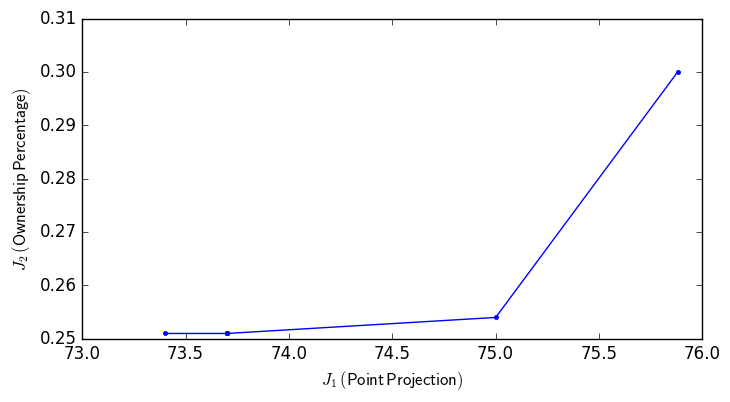

In [5]:
using PyPlot

Npts = 10                 # Number of points to be tested
J1 = zeros(Npts)          # Vector containing projected points
J2 = zeros(Npts)          # Vector containing sum of ownership percentages
pp = zeros(size(raw)[1], Npts)         # Player indicator vectors

# Run weekly model for each test point
for (i,λ) in enumerate(logspace(1,15,Npts))
    (J1[i],J2[i],pp[:,i]) = weeklyModel(λ, QBlimit, RBlimit, TElimit, WRlimit, FXlimit, TMlimit, salaryCap, week, df)
end;

# Plot tradeoff curve
figure(figsize=(8,4))
plot( J1, J2, "b.-" )
xlabel(L"J_1\, (\sf Point\, Projection)")
ylabel(L"J_2\, (\sf Ownership\, Percentage)");


#### Discussion of Results

The weekly model optimizer provides a roster that best utilizes the available players given player projections, salary, and ownership percentage for a given week.  The projected point total increases with salary, number of players allowed from a unique team, and number of players at each position.  Introducing more flex positions will increase the projected points more than increasing a specific position.

   The point total decreases with an increase in the tradeoff parameter for salary, as expected.  This tradeoff is plotted here.  One hopes to attain the highest point total and lowest ownership percentage, making the bottom right of the graph most desirable.  Unfortunately, with the data attained, not many points are shown on the graph.  Making the salary constraints looser and increasing the position limits will give a few more points.  As expected, there is an upward sloping curve or line representing the tradeoff from low points and ownership percentage, to high points and ownership percentage.

   Below is a link to the adjustable parameters.  I encourage you to play around with them and observe the effects described above.

[Adjust Parameters](#4A.-Weekly-Model-Results)

### 4C. Season Model Results
Note: Be sure to run the [season model](#3B.-Season-Model) first

#### Parameters

Salary Caps - We advise that weekly salary cap should be greater than or equal to 4000 times the number of players required to fill the roster.  In order for the season cap to be relevant, make it less than 10 times the weekly cap.  However, making it significantly less than the weekly cap can eliminate the effects of the weekly cap or result in infeasibility.  Relaxing salary constraints will show a better tradeoff between points and transactions.

Tradeoff Parameter - Transaction cost must be greater than or equal to 0 and may be a decimal.  Varying transaction cost from 0 to 10 provides a good variety of linups and transaction sequences, as shown by the tradeoff plot.

Position limits - Must be greater than or equal to 0.  Increasing the position limits will give more variety in output when changing other parameters.  However, increasing the total number of players will increase the time it takes to optimize.  For the tradeoff plot, we suggest that total players should not exceed 12.

#### Adjust your parameters here:

In [6]:
using DataFrames

# Choose Data Set
trial = "PritzlColla_trial.csv"
full = "PritzlColla_full.csv"
chosenData = full

raw = DataFrame(readtable(chosenData, header = true));

# Season Model Salary Caps
seasonCap = 280000;
weeklyCap = 30000;

# Tradeoff Parameter
transCost=3;

# Amount of Players for each Position
QBlimit = 1;
RBlimit = 2;
TElimit = 1;
WRlimit = 2;
FXlimit = 1;

In [9]:
using JuMP

# Run season model for given parameters
(J1, J2, xopt, zopt, pts, cost) = seasonModel(transCost, QBlimit, RBlimit, TElimit, WRlimit, FXlimit, seasonCap, weeklyCap, raw)
N = size(xopt)[1]     # Number of players in roster
M = size(xopt)[2]     # Number of weeks

# Create week 1 roster data frame
start = DataFrame(Player = UTF8String[], Position = UTF8String[], Team = UTF8String[])

for i = 1:N
    if xopt[i,1]==1
        push!(start, [raw[i,1] raw[i,2] raw[i,3]])
    end
end

# Display week 1 roster
start

7×3 DataFrames.DataFrame
│ Row │ Player              │ Position │ Team  │
├─────┼─────────────────────┼──────────┼───────┤
│ 1   │ "Ryan Mallett"      │ "QB"     │ "HOU" │
│ 2   │ "Frank Gore"        │ "RB"     │ "IND" │
│ 3   │ "LeGarrette Blount" │ "RB"     │ "NE"  │
│ 4   │ "Zach Ertz"         │ "TE"     │ "PHI" │
│ 5   │ "Scott Chandler"    │ "TE"     │ "NE"  │
│ 6   │ "Travis Benjamin"   │ "WR"     │ "SD"  │
│ 7   │ "Nate Washington"   │ "WR"     │ "NE"  │

In [10]:
# Create Summary Table
summary = DataFrame(Week = Int64[], Projection = Float64[], Salary = Int64[], Transactions = Int64[])

points = zeros(M)         # Vector of projected points for each week
salary = zeros(M)         # Vector of salary for each week
transactions = zeros(M)   # Vector of transactions for each week
for i = 1:N
    for j = 2:M
        transactions[j] = transactions[j] + .5*zopt[i,j-1]     # Take half since each transaction is counted twice
    end
end
for j = 1:M
    for i = 1:N
        if xopt[i,j]==1
            points[j] = points[j] + pts[i,j]
            salary[j] = salary[j] + cost[i,j]
        end
    end
end
for j = 1:M
    push!(summary, [j round(points[j],3) salary[j] transactions[j]])
end

# Display summary
summary

10×4 DataFrames.DataFrame
│ Row │ Week │ Projection │ Salary │ Transactions │
├─────┼──────┼────────────┼────────┼──────────────┤
│ 1   │ 1    │ 58.94      │ 26300  │ 0            │
│ 2   │ 2    │ 69.9       │ 28400  │ 1            │
│ 3   │ 3    │ 73.42      │ 28400  │ 2            │
│ 4   │ 4    │ 80.88      │ 29800  │ 1            │
│ 5   │ 5    │ 72.28      │ 26900  │ 2            │
│ 6   │ 6    │ 72.98      │ 27500  │ 0            │
│ 7   │ 7    │ 74.4       │ 28700  │ 2            │
│ 8   │ 8    │ 82.36      │ 29900  │ 2            │
│ 9   │ 9    │ 78.18      │ 29500  │ 0            │
│ 10  │ 10   │ 31.8       │ 24500  │ 0            │

In [11]:
# Create Transaction List
translist = DataFrame(AddPlayer = UTF8String[], AddPos = UTF8String[], AddTeam = UTF8String[],
    Week = Int64[], DropPlayer = UTF8String[], DropPos = UTF8String[], DropTeam = UTF8String[])

addrow = Int64[]      # Players that are added at some point during the season
droprow = Int64[]     # Players that are dropped at some point during the season
transcol = Int64[]    # Week of a particular transaction
for j = 2:M
    for i = 1:N
        if xopt[i,j]-xopt[i,j-1] == 1         # If player is added
            push!(addrow, i)                  # Add row index to addrow vector
            push!(transcol, j)                # Add column index to transcol vector
        elseif xopt[i,j]-xopt[i,j-1] == -1    # If player is dropped
            push!(droprow, i)                 # Add row index to droprow vector
        end
    end
end
for i=1:length(addrow)    # For each transaction, record name, position, team, and week of added and dropped player
    push!(translist, [raw[addrow[i], 1], raw[addrow[i], 2], raw[addrow[i], 3],
        transcol[i], raw[droprow[i], 1], raw[droprow[i], 2], raw[droprow[i], 3]])
end

# Display transaction list
translist

10×7 DataFrames.DataFrame
│ Row │ AddPlayer           │ AddPos │ AddTeam │ Week │ DropPlayer          │
├─────┼─────────────────────┼────────┼─────────┼──────┼─────────────────────┤
│ 1   │ "Leonard Hankerson" │ "WR"   │ "ATL"   │ 2    │ "Nate Washington"   │
│ 2   │ "Ryan Fitzpatrick"  │ "QB"   │ "NYJ"   │ 3    │ "Ryan Mallett"      │
│ 3   │ "Mike Wallace"      │ "WR"   │ "MIN"   │ 3    │ "Travis Benjamin"   │
│ 4   │ "Jonathan Stewart"  │ "RB"   │ "CAR"   │ 4    │ "Zach Ertz"         │
│ 5   │ "Heath Miller"      │ "TE"   │ "PIT"   │ 5    │ "Frank Gore"        │
│ 6   │ "Malcom Floyd"      │ "WR"   │ "SD"    │ 5    │ "Leonard Hankerson" │
│ 7   │ "Zach Ertz"         │ "TE"   │ "PHI"   │ 7    │ "Heath Miller"      │
│ 8   │ "Travis Benjamin"   │ "WR"   │ "SD"    │ 7    │ "Malcom Floyd"      │
│ 9   │ "Coby Fleener"      │ "TE"   │ "IND"   │ 8    │ "Zach Ertz"         │
│ 10  │ "Nate Washington"   │ "WR"   │ "NE"    │ 8    │ "Mike Wallace"      │

│ Row │ DropPos │ DropTeam │
├─────┼─────────┼──────────┤
│ 1   │ "WR"    │ "NE"     │
│ 2   │ "QB"    │ "HOU"    │
│ 3   │ "WR"    │ "SD"     │
│ 4   │ "TE"    │ "PHI"    │
│ 5   │ "RB"    │ "IND"    │
│ 6   │ "WR"    │ "ATL"    │
│ 7   │ "TE"    │ "PIT"    │
│ 8   │ "WR"    │ "SD"     │
│ 9   │ "TE"    │ "PHI"    │
│ 10  │ "WR"    │ "MIN"    │

### 4D. Tradeoff Curve:  Points vs Transactions

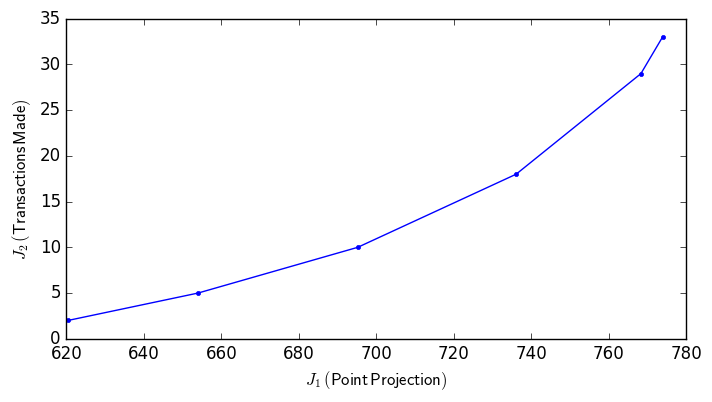

In [12]:
using PyPlot

testCosts=[.5,1,2,3,5,7]                  # Transaction costs to be tested
J1 = zeros(length(testCosts))             # Vector of projected points
J2 = zeros(length(testCosts))             # Vector of transactions

# Run season model for each test point
for (i,λ) in enumerate(testCosts)
    (J1[i],J2[i]) = seasonModel(testCosts[i], QBlimit, RBlimit, TElimit, WRlimit, FXlimit, seasonCap, weeklyCap, raw)
end;

# Plot tradeoff curve
figure(figsize=(8,4))
plot( J1, J2, "b.-" )
xlabel(L"J_1\, (\sf Point\, Projection)")
ylabel(L"J_2\, (\sf Transactions\, Made)");

#### Discussion of Results

The seasonal model optimizes a roster for each week of the season, given projected points and salary.  The output is split into three parts.  The first table shows the optimal week one lineup.  Next, a summary of the projected points and salary for each week’s lineup is shown.  Finally, a transaction table provides the transactions that are to be made to achieve optimality.

Just as the weekly model suggests, the projected season points increase with an increase in salary and position limits. Adjusting salary can greatly change your weekly lineups and transactions.

Projected points and transaction also have a positive relationship.  Ideally, one would like the highest projected points and the lowest transaction cost.  The tradeoff curve is plotted.  As expected, there is an upward sloping curve.  Each point on this curve is optimal.  It is up to the user to determine how much they want to spend on their team to achieve maximum points.

Below is a link to the adjustable parameters.  I encourage you to play around with them and observe the effects described above.


[Adjust Parameters](#4C.-Season-Model-Results)

### 4E. Model Limitations and Further Improvements

One limitation of these models is the quality of data.  Using these models effectively relies heavily on the quality of data being used.  Since the intent of this project was not to assess the data quality, the results serve no purpose other than to validate that the model is indeed working.  The proceedure for obtaining the data used in this reports is in [Appendix A](#Appendix-A:--Data)

A simple improvement to the weekly model could be to introduce a standard deviation variable for each of the players.  Including this variable essentially makes each player act as an investment, and now the problem becomes quite similar to financial optimization, resulting in an efficient frontier of possible rosters.

Further improvements for the weekly model can be made through the implementation of ownership percentages.  In order to truly capture the gains from knowing ownership percentages, a product should be included in the objective function rather than a sum.

Another way of approaching the ownership percentage implementation problem is to create more than one tradeoff parameter for ownership percentages.  A user may want to minimize the chance that another competitor has 3 of the same players, rather than all of the same players.  Finding the ideal setting for these tradeoff parameters is another study in itself.

This model could also be transformed into a combinatorial optimization problem where the user can attempt to maximize their chance of placing in a payout position.

There are more variables beyond ownership percentage that can increase the chances of winning a fantasy league that are not considered here.  It is important to understand that these models are sound for their intended purpose, but require extensive reconstruction to be used for real world applications.


## 5. Conclusion

This report presents two models used to optimize a fantasy football roster in different scenarios.  We examined the tradeoff between points in salary though an adjustable parameter and hard constraint.  We also looked at the tradeoff between points and ownership percentage, as well as points and transaction cost.  However, as discussed previously, the model is only as good as the quality of data.  Optimizing a roster relies on three important variables:  points, salary, and ownership percentage.  In real world applications, salary is given, but points and ownership percentage are not.  Therefore, further regression research should be done to predict points and ownership percentage.  Better predictions lead to better data, ultimately ending in better results and returns. 

[Back to top](#Table-of-Contents)

### Appendix A:  Data

Obtaining the full data set:

Only weeks 3, 5 through 10, 12, 13, and 15 had data on ownership percentages.  Only the top 50 players from each position each week were available for free, so there was plenty of missing data.  We attempted to make proxies for the missing data so we could have a full data set.  Since the data is not the main concern of this project, we didn’t spend much time determining the best proxies.  For missing projections, salaries, and ownership percentages, we assigned the lowest value of their respective position (e.g. if a projection was missing for a quarterback and the lowest quarterback projection was 5.4 points, they were assigned 5.4 points).  Also, only the players that were significantly owned in week 3 were used as observations for simplicity.

Making the trial data set:

Only two players from each of two postions are used.  Two of the players are from the same team.  Only two weeks of data was made up.  The remaining weeks are filled in as 1 so that the dimensions line up.